In [1]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt

In [2]:
def extract_metadata_from_filename(filename: str) -> dict:
    # print(filename)
    pattern = re.compile(r"(?P<num_producers>\d+)p(?P<num_consumers>\d+)c(?P<num_topics>\d+)t(?P<message_size>\d+)_0b\-(?P<duration_messages>\d+[ms])_(?P<container_name>[a-zA-Z_\-0-9]*)\.csv")
    match = pattern.search(filename)
    if not match:
        raise ValueError(f"Could not parse metadata from filename: {filename}")
    
    return {
        "num_producers": int(match.group("num_producers")),
        "num_consumers": int(match.group("num_consumers")),
        "num_topics": int(match.group("num_topics")),
        "message_size": int(match.group("message_size")),
        "container_name": match.group("container_name"),
        "duration_messages": match.group("duration_messages"),
    }

def extract_tech(filepath):
    return os.path.basename(os.path.dirname(filepath))

In [3]:
def load_all_stats(root="../logs"):
    all_rows = []
    for dirpath, _, filenames in os.walk(root):
        for fname in filenames:
            if not fname.endswith(".csv"):
                continue
            full_path = os.path.join(dirpath, fname)
            try:
                df = pd.read_csv(full_path, parse_dates=["timestamp"])
                df["timestamp"] = pd.to_datetime(df["timestamp"])
                
                tech = extract_tech(full_path)
                meta = extract_metadata_from_filename(fname)
                meta["technology"] = tech
                
                for k, v in meta.items():
                    df[k] = v
                all_rows.append(df)
            except Exception as e:
                print(f"Failed to load {fname}: {e}")
    if not all_rows:
        raise RuntimeError("No stats files loaded.")
    
    full_df = pd.concat(all_rows, ignore_index=True)
    
    return full_df


In [4]:
def assign_elapsed_time(df: pd.DataFrame) -> pd.DataFrame:
    # Define a scenario grouping key — use only the dimensions relevant to the scenario identity
    scenario_cols = [
        "num_producers", "num_consumers", "num_topics",
        "message_size", "technology"  # feel free to include more later
    ]
    
    # Find the earliest timestamp per scenario group
    min_timestamps = df.groupby(scenario_cols)["timestamp"].min().rename("scenario_start")

    # Join back to original DataFrame to align scenario-relative time
    df = df.merge(min_timestamps, on=scenario_cols)

    # Compute aligned elapsed time
    df["elapsed_time"] = (df["timestamp"] - df["scenario_start"]).dt.total_seconds() * 1000
    df = df.drop(columns="scenario_start")

    return df


In [5]:
stats_df = load_all_stats("../logs/mems_simulator/")
stats_df = stats_df.drop(stats_df[stats_df.container_name.str.contains("broker")].index)
stats_df = assign_elapsed_time(stats_df)
stats_df

,timestamp,cpu_usage_ns,cpu_usage_perc,memory_usage,network_rx,network_tx,disk_read,disk_write,num_producers,num_consumers,num_topics,message_size,container_name,duration_messages,technology,elapsed_time
0,2025-04-18 19:37:32.718194,16610300,0.00,5881856,2973,1884,0,0,1,1,1,102400,kafka-C0,300s,kafka,0.000
1,2025-04-18 19:37:35.958670,127307300,3.67,46350336,63004736,42995,0,0,1,1,1,102400,kafka-C0,300s,kafka,3240.476
2,2025-04-18 19:37:38.978938,1359500100,40.77,90386432,449414456,313248,0,0,1,1,1,102400,kafka-C0,300s,kafka,6260.744
3,2025-04-18 19:37:41.988109,2501803400,37.86,90431488,780172687,533865,0,0,1,1,1,102400,kafka-C0,300s,kafka,9269.915
4,2025-04-18 19:37:45.012213,3901322500,34.83,85229568,1169727966,778940,0,0,1,1,1,102400,kafka-C0,300s,kafka,12294.019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14668,2025-04-19 06:35:07.623254,489552778900,180.21,3403776,412348418,3475106975,0,0,1,2,1,64,zeromq_p2p-P0,300s,zeromq_p2p,281919.424
14669,2025-04-19 06:35:11.634624,496541419100,178.92,3543040,418290200,3524598148,0,0,1,2,1,64,zeromq_p2p-P0,300s,zeromq_p2p,285930.794
14670,2025-04-19 06:35:15.642703,503539171800,180.19,3973120,424069820,3574122609,0,0,1,2,1,64,zeromq_p2p-P0,300s,zeromq_p2p,289938.873
14671,2025-04-19 06:35:19.666848,510531636600,180.54,3485696,430061630,3624386638,0,0,1,2,1,64,zeromq_p2p-P0,300s,zeromq_p2p,293963.018


In [6]:
def filter_stats(df, *, technology=None, num_producers=None, num_consumers=None,
                 num_topics=None, message_size=None, role=None):
    filtered = df.copy()
    if technology:
        filtered = filtered[filtered["technology"] == technology]
    if num_producers:
        filtered = filtered[filtered["num_producers"] == num_producers]
    if num_consumers:
        filtered = filtered[filtered["num_consumers"] == num_consumers]
    if num_topics:
        filtered = filtered[filtered["num_topics"] == num_topics]
    if message_size:
        filtered = filtered[filtered["message_size"] == message_size]
    if role:
        filtered = filtered[filtered["container_name"].str.contains(f"-{role[0].upper()}")]
    return filtered


In [7]:
def plot_metric_over_dimension(df, metric, title=None, x="elapsed_time", facet_by="container_name", agg_func="mean", unit_x = "ms", unit_y = None):
    plt.figure(figsize=(12, 6))
    if x in ["timestamp", "elapsed_time"]:
        # Time series mode — no aggregation
        for label, group in df.groupby(facet_by):
            plt.plot(group[x], group[metric], label=label)
        plt.xlabel(f"{x} ({unit_x})")
    else:
        # Dimensional mode — needs aggregation
        agg_df = (
            df.groupby([x, facet_by])[metric]
            .agg(agg_func)
            .reset_index()
            .sort_values(by=x)
        )

        for label, group in agg_df.groupby(facet_by):
            plt.plot(group[x], group[metric], marker="o", label=label)
        plt.xlabel("Time (ms)")

    plt.title(title or f"{metric} over time")
    plt.ylabel(metric.replace("_", " ").title() + f" ({unit_y})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


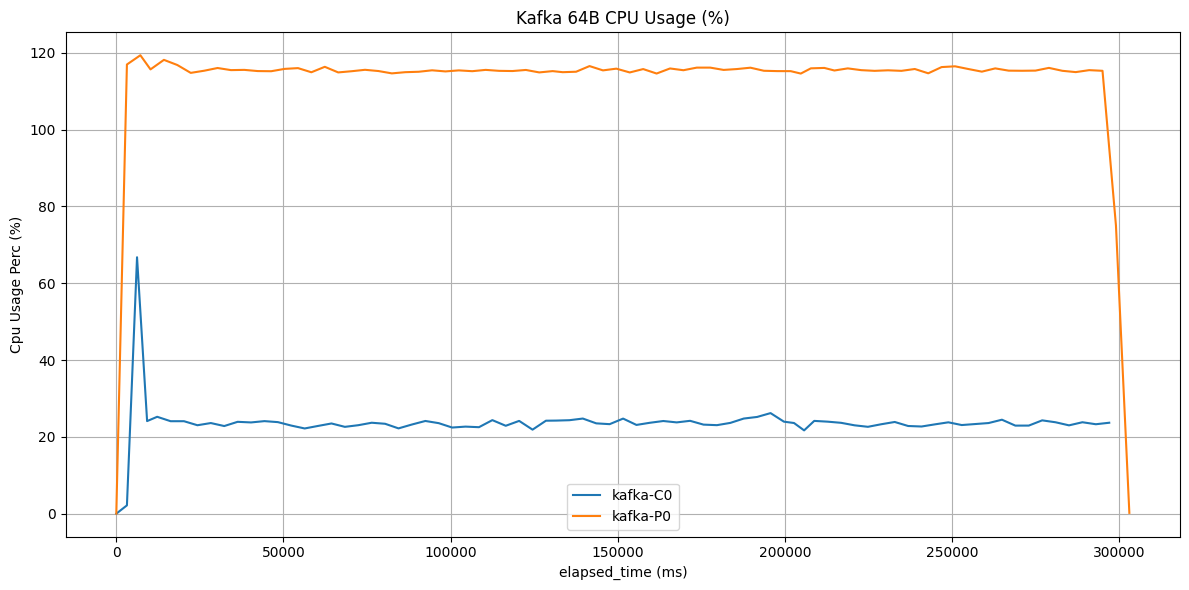

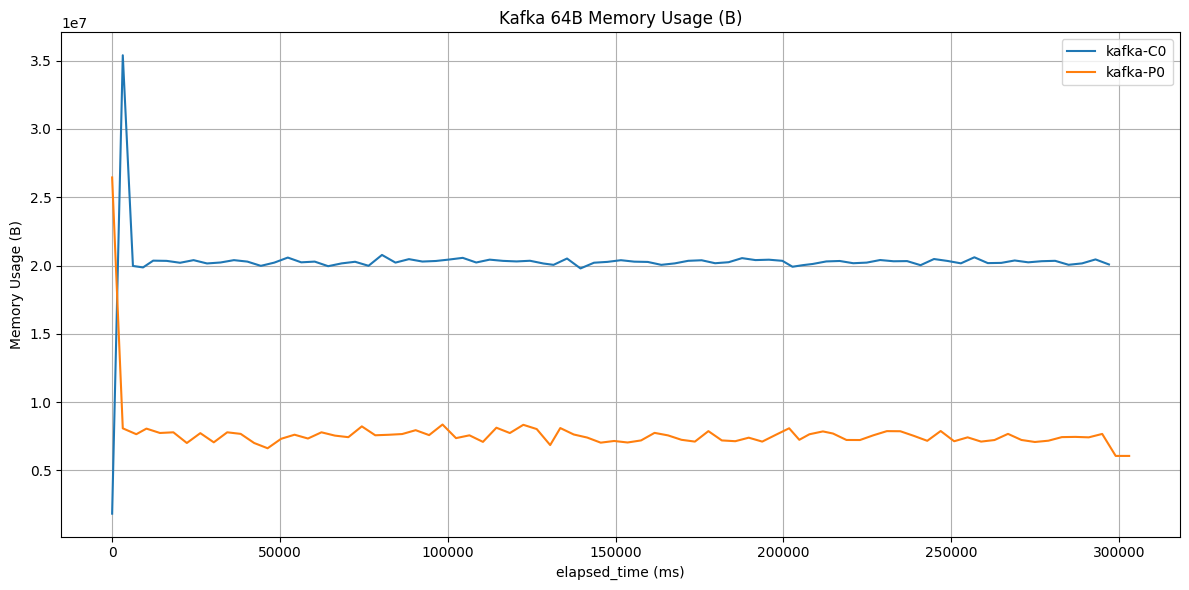

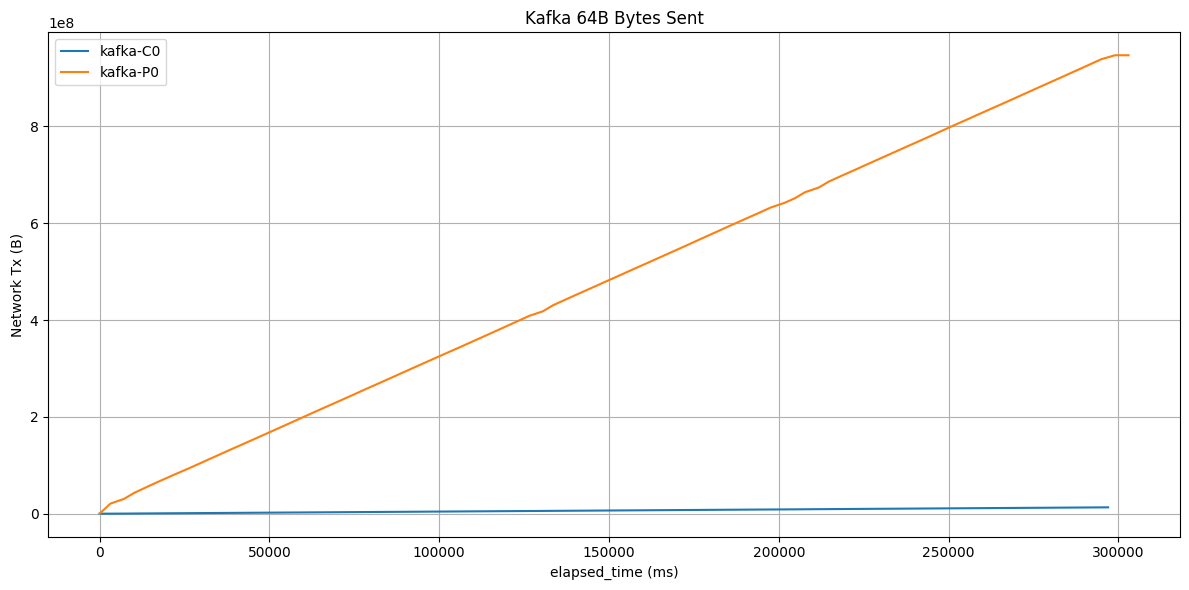

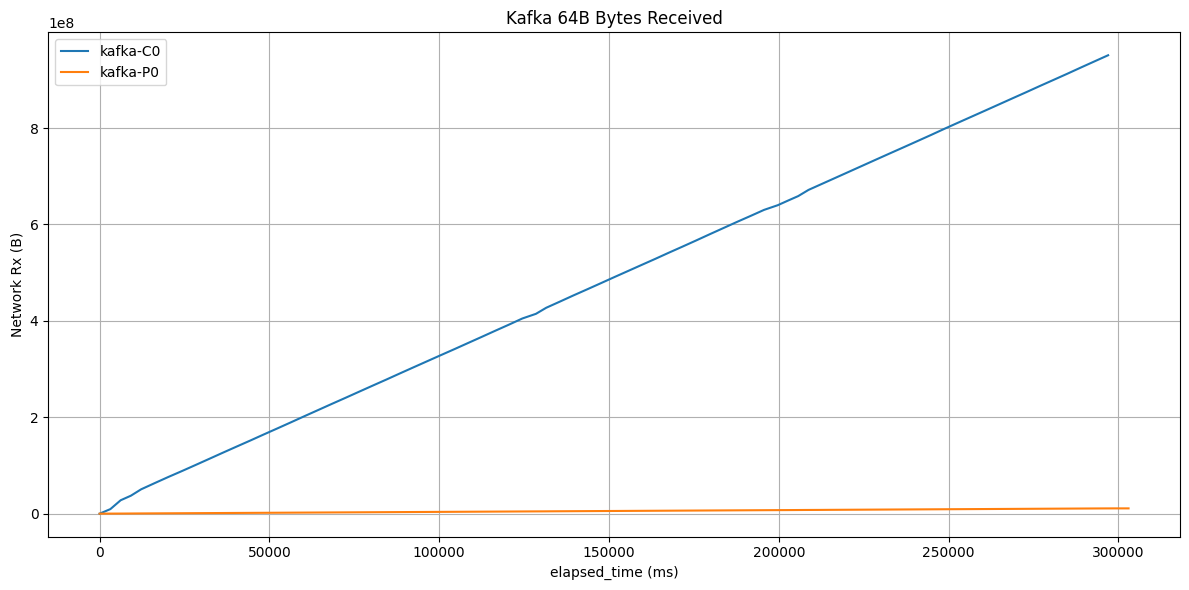

In [8]:
# Slice only kafka data with 64B messages and 4 topics
df_kafka_64 = filter_stats(stats_df, technology="kafka", message_size=64, num_topics=1, num_consumers=1)

# Plot CPU usage for those containers
plot_metric_over_dimension(df_kafka_64, "cpu_usage_perc", "Kafka 64B CPU Usage (%)", unit_y="%")
plot_metric_over_dimension(df_kafka_64, "memory_usage", "Kafka 64B Memory Usage (B)", unit_y="B")
plot_metric_over_dimension(df_kafka_64, "network_tx", "Kafka 64B Bytes Sent", unit_y="B")
plot_metric_over_dimension(df_kafka_64, "network_rx", "Kafka 64B Bytes Received", unit_y="B")

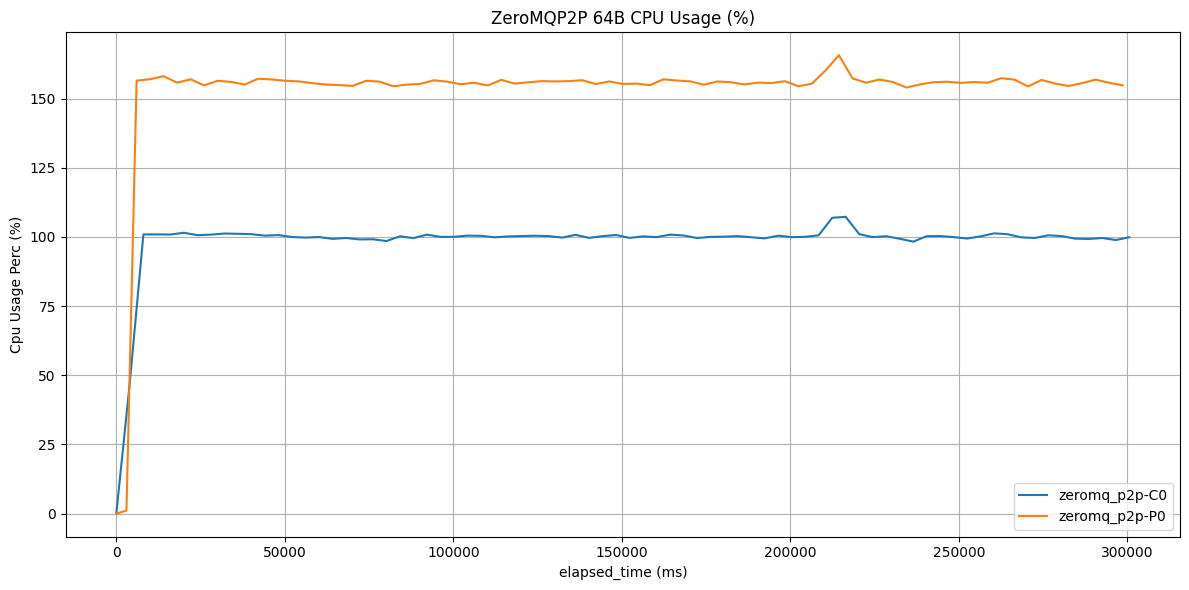

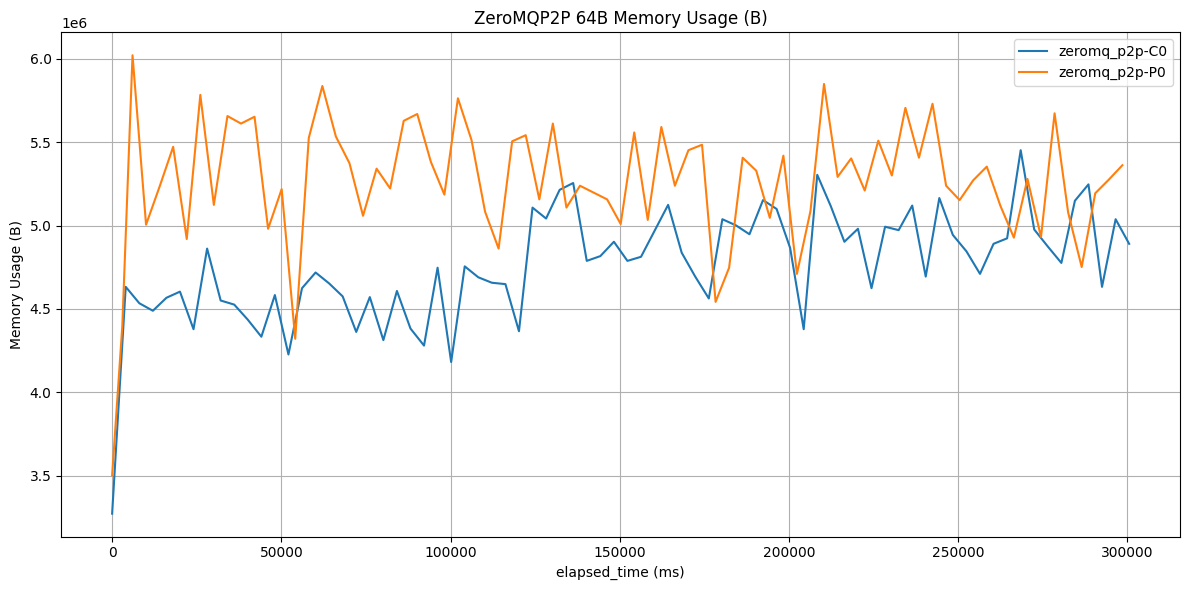

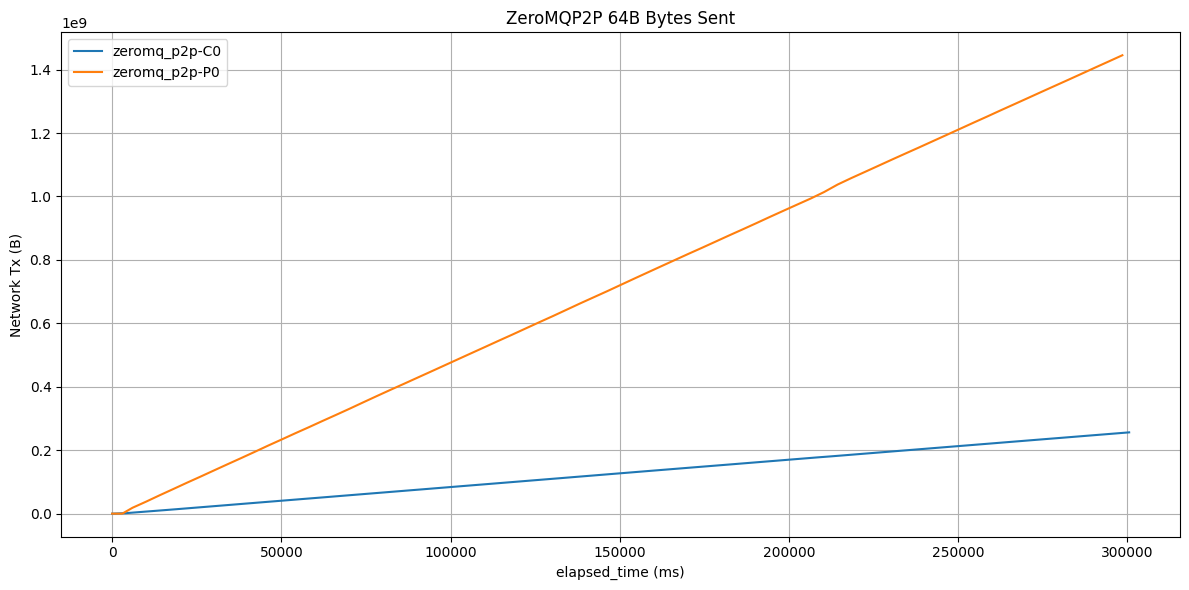

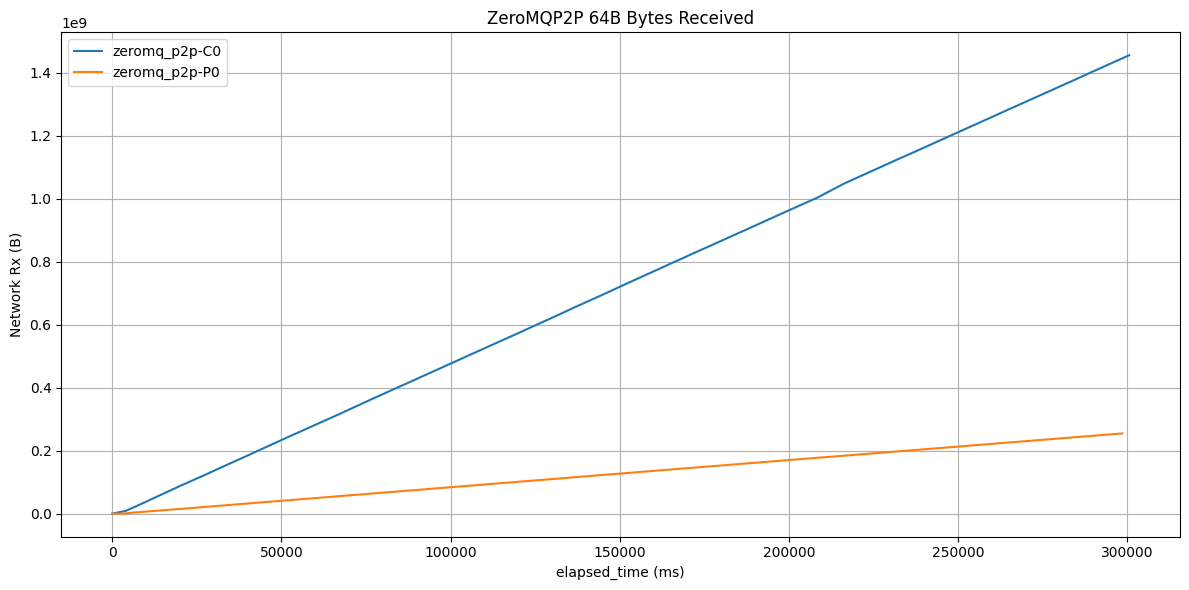

In [10]:
# Slice only zeromq_p2p data with 64B messages and 4 topics
df_zmq_64 = filter_stats(stats_df, technology="zeromq_p2p", message_size=64)

# Plot CPU Usage (%) for those containers
plot_metric_over_dimension(df_zmq_64, "cpu_usage_perc", "ZeroMQP2P 64B CPU Usage (%)", unit_y="%")
plot_metric_over_dimension(df_zmq_64, "memory_usage", "ZeroMQP2P 64B Memory Usage (B)", unit_y="B")
plot_metric_over_dimension(df_zmq_64, "network_tx", "ZeroMQP2P 64B Bytes Sent", unit_y="B")
plot_metric_over_dimension(df_zmq_64, "network_rx", "ZeroMQP2P 64B Bytes Received", unit_y="B")

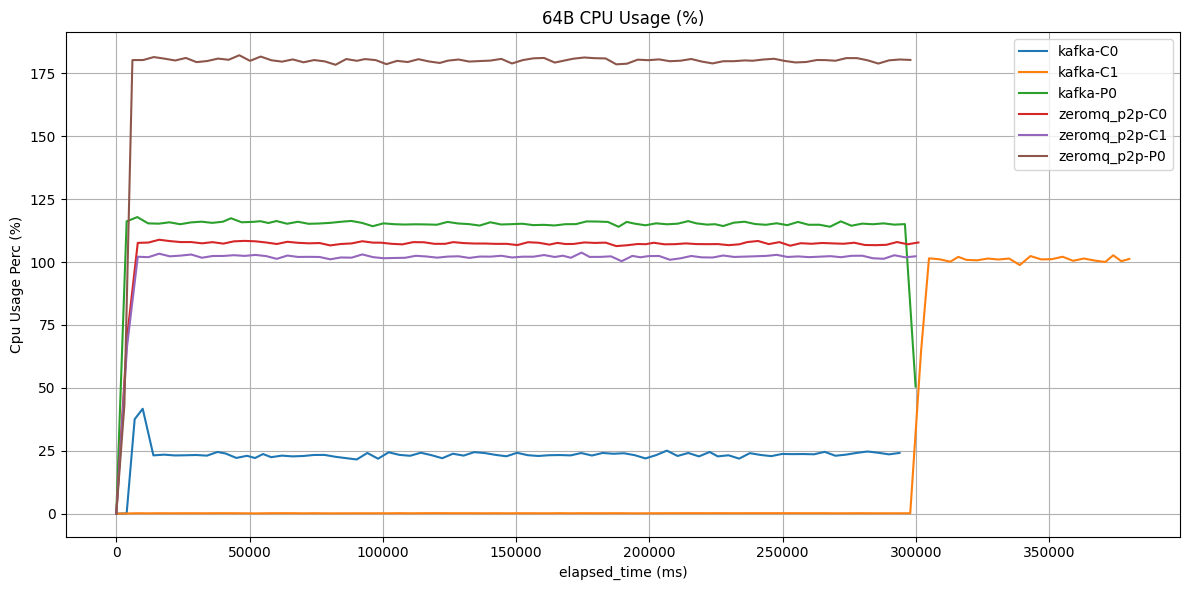

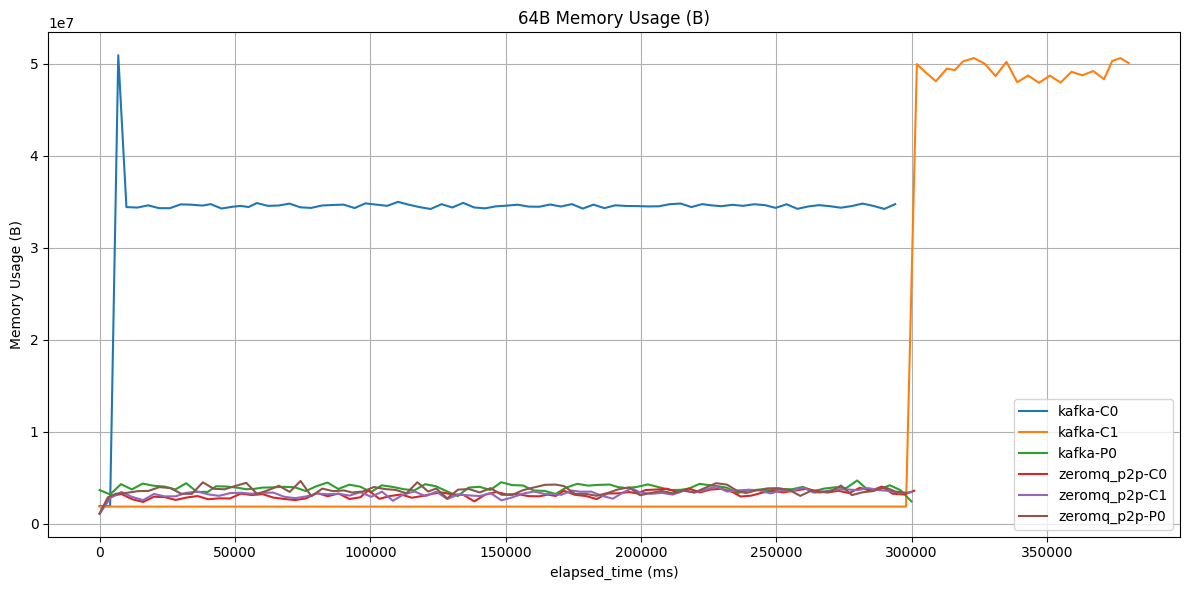

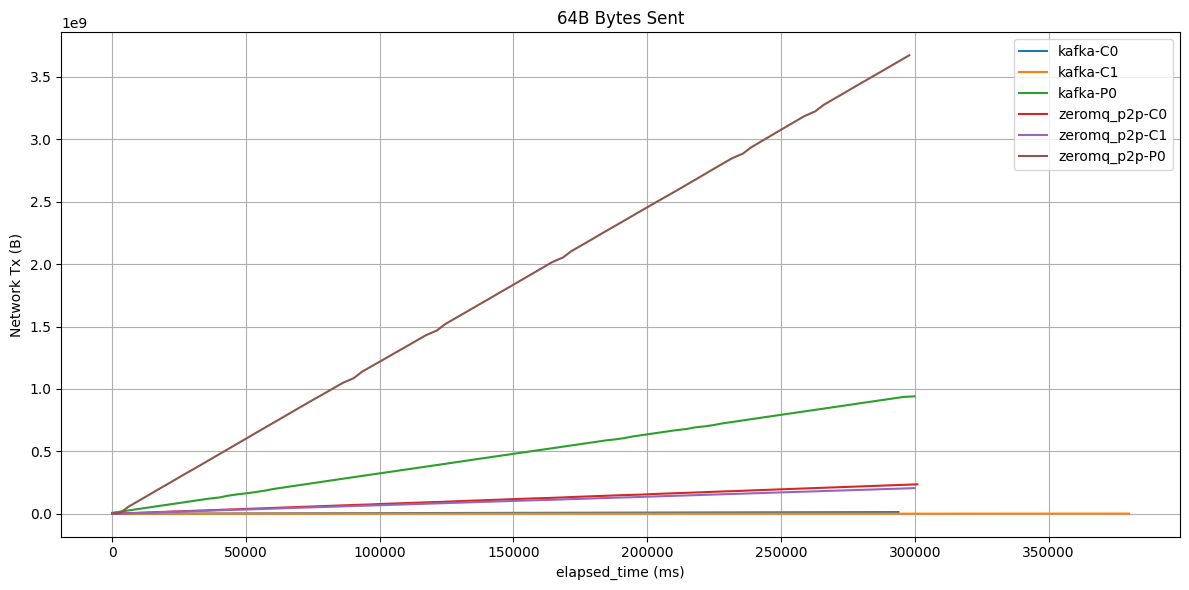

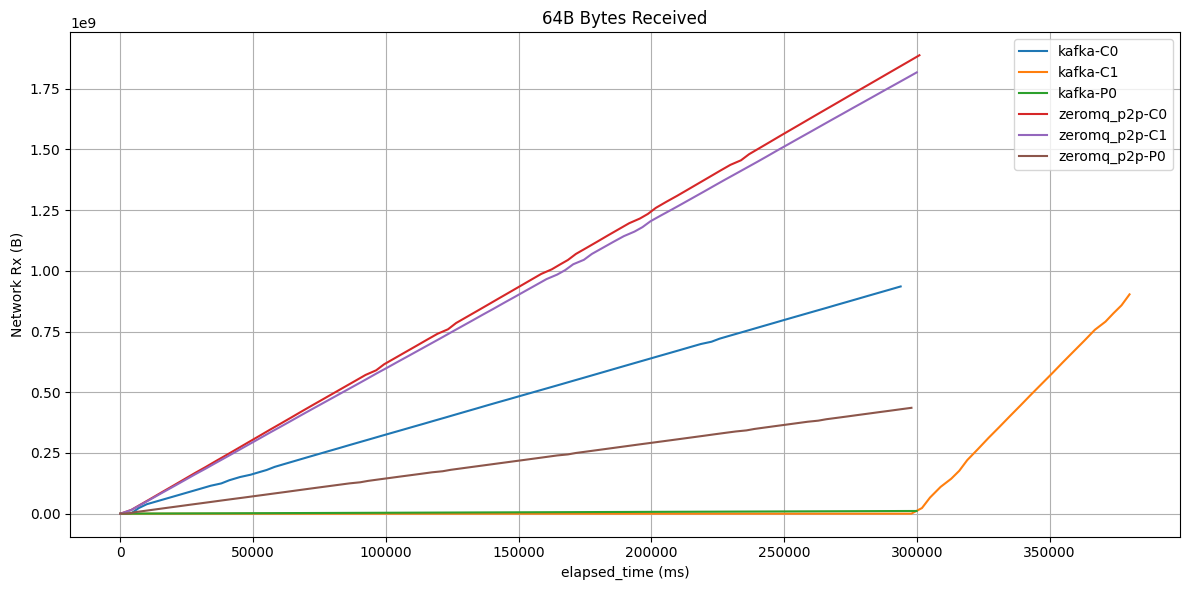

In [12]:
# Slice only data with 64B messages and 4 topics
df_64 = filter_stats(stats_df, message_size=64, num_topics=1, num_consumers=2)

# Plot CPU Usage (%) for those containers
plot_metric_over_dimension(df_64, "cpu_usage_perc", "64B CPU Usage (%)", unit_y="%")
plot_metric_over_dimension(df_64, "memory_usage", "64B Memory Usage (B)", unit_y="B")
plot_metric_over_dimension(df_64, "network_tx", "64B Bytes Sent", unit_y="B")
plot_metric_over_dimension(df_64, "network_rx", "64B Bytes Received", unit_y="B")

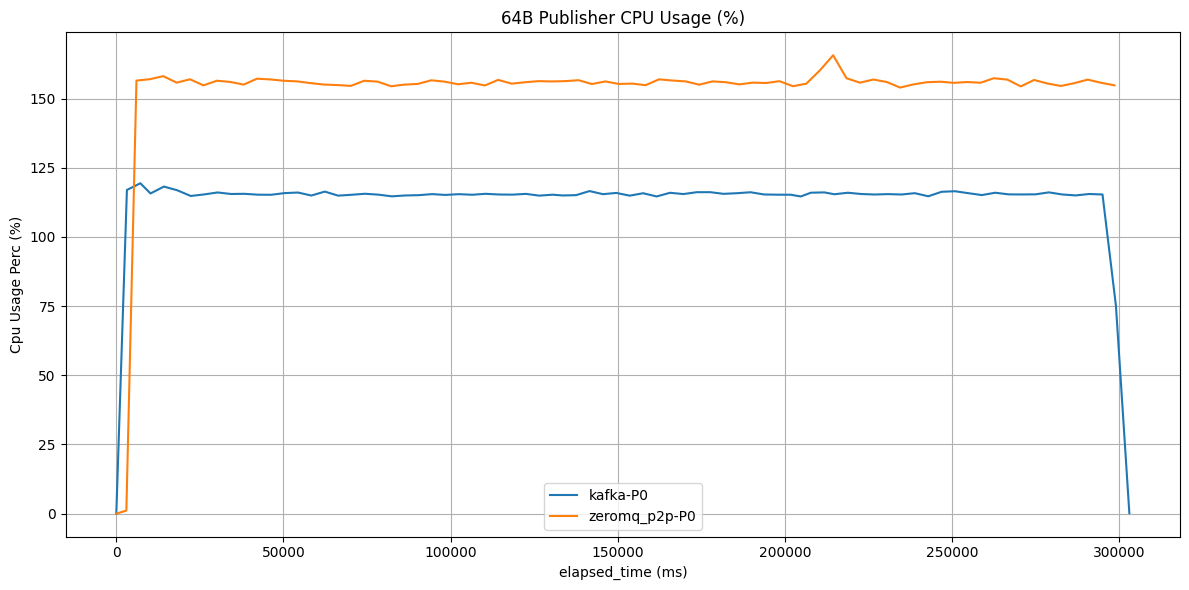

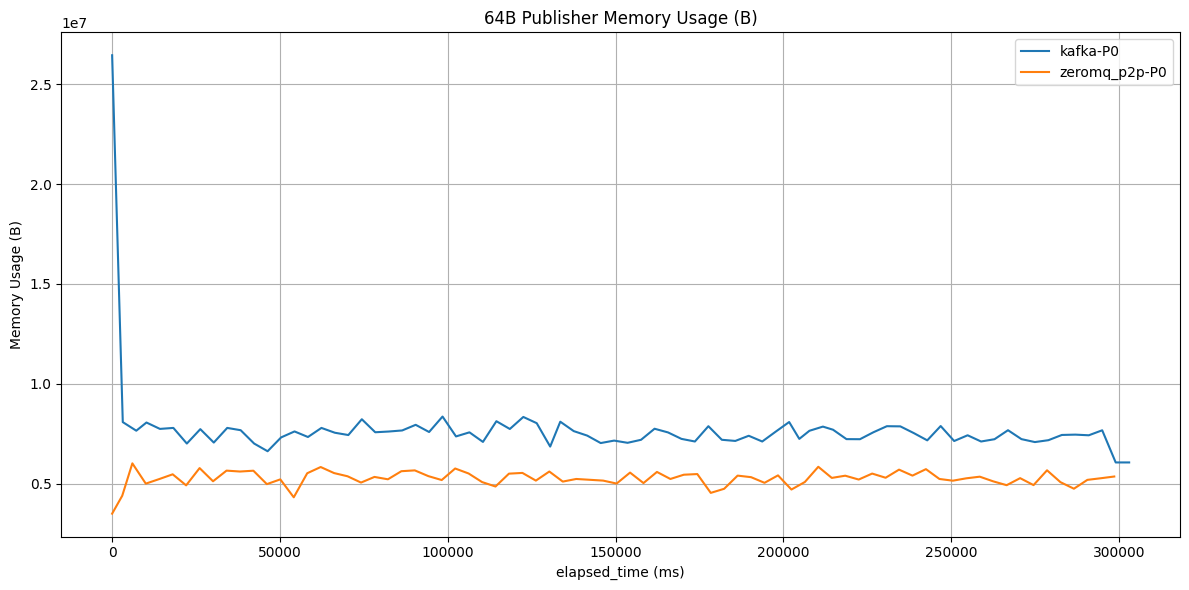

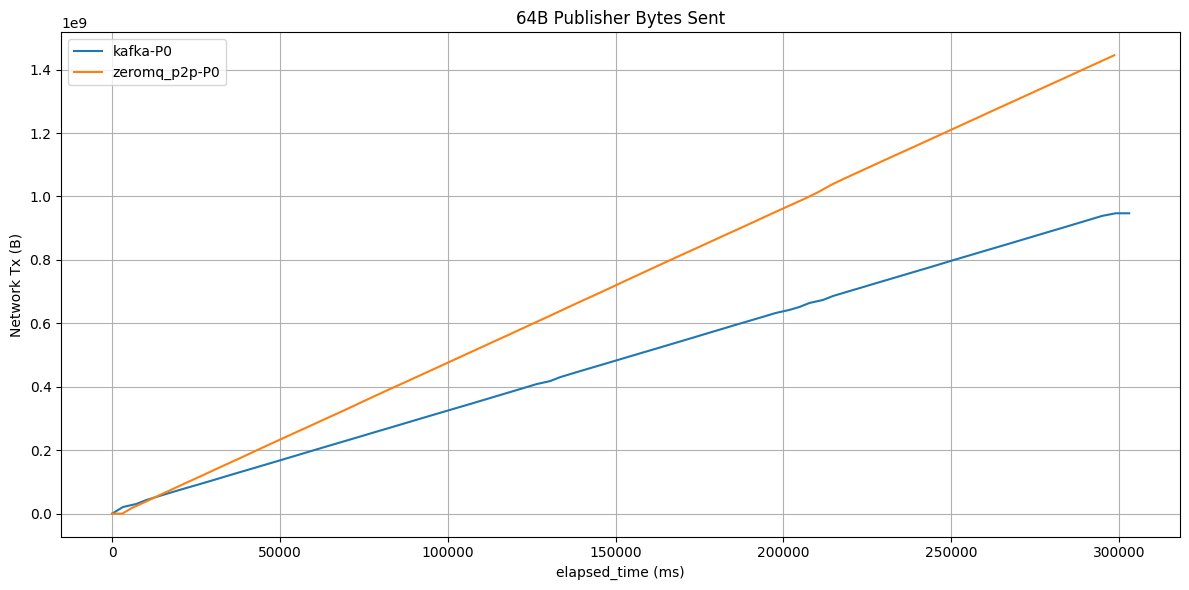

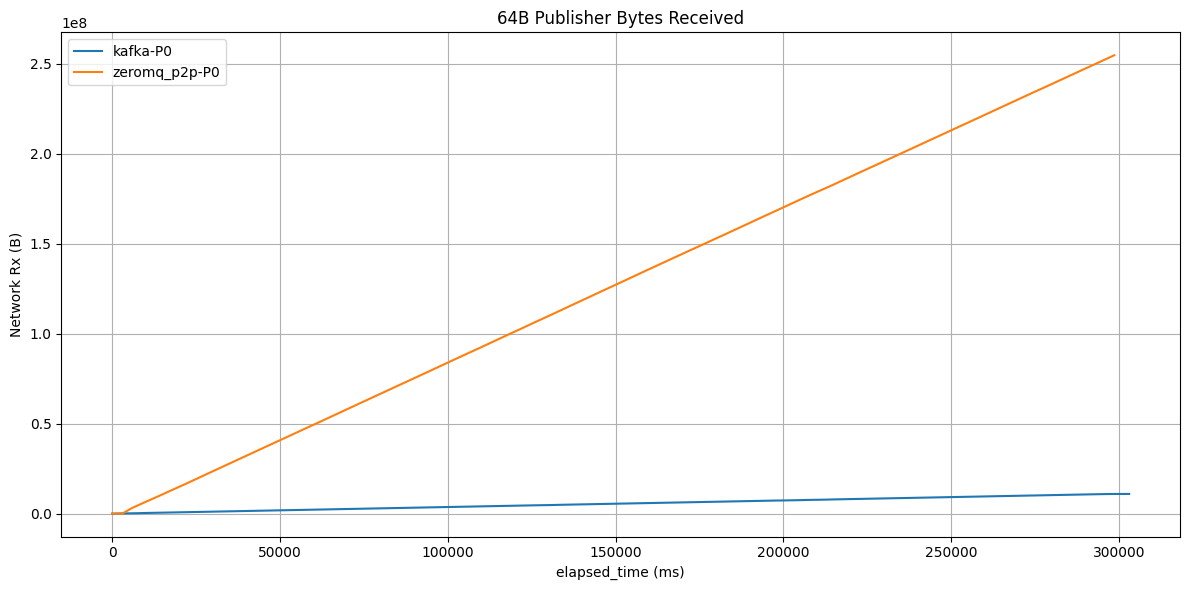

In [13]:
# Slice only publisher data with 64B messages and 4 topics
df_pub_64 = filter_stats(stats_df, role = "Publisher", message_size=64, num_topics=1, num_consumers=1)

# Plot CPU Usage (%) for those containers
plot_metric_over_dimension(df_pub_64, "cpu_usage_perc", "64B Publisher CPU Usage (%)", unit_y="%")
plot_metric_over_dimension(df_pub_64, "memory_usage", "64B Publisher Memory Usage (B)", unit_y="B")
plot_metric_over_dimension(df_pub_64, "network_tx", "64B Publisher Bytes Sent", unit_y="B")
plot_metric_over_dimension(df_pub_64, "network_rx", "64B Publisher Bytes Received", unit_y="B")

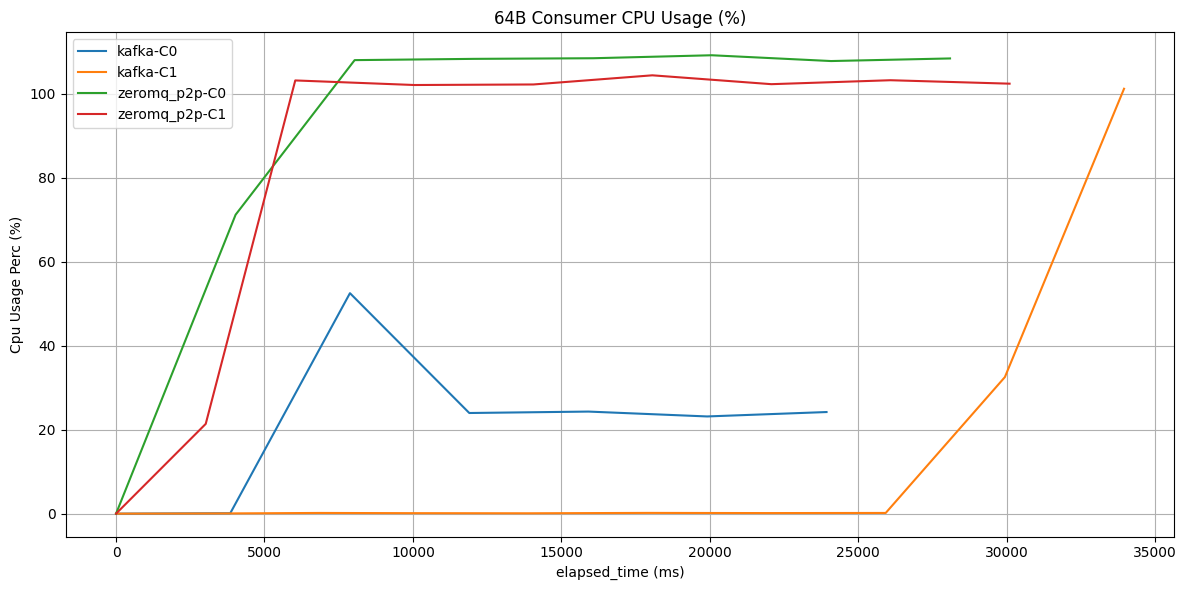

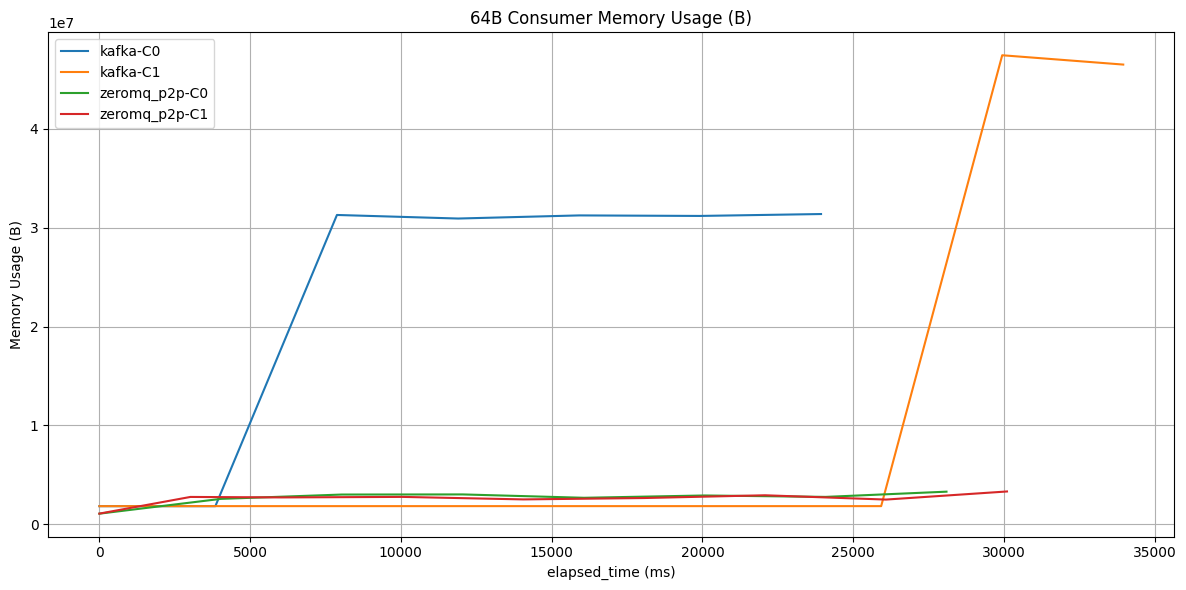

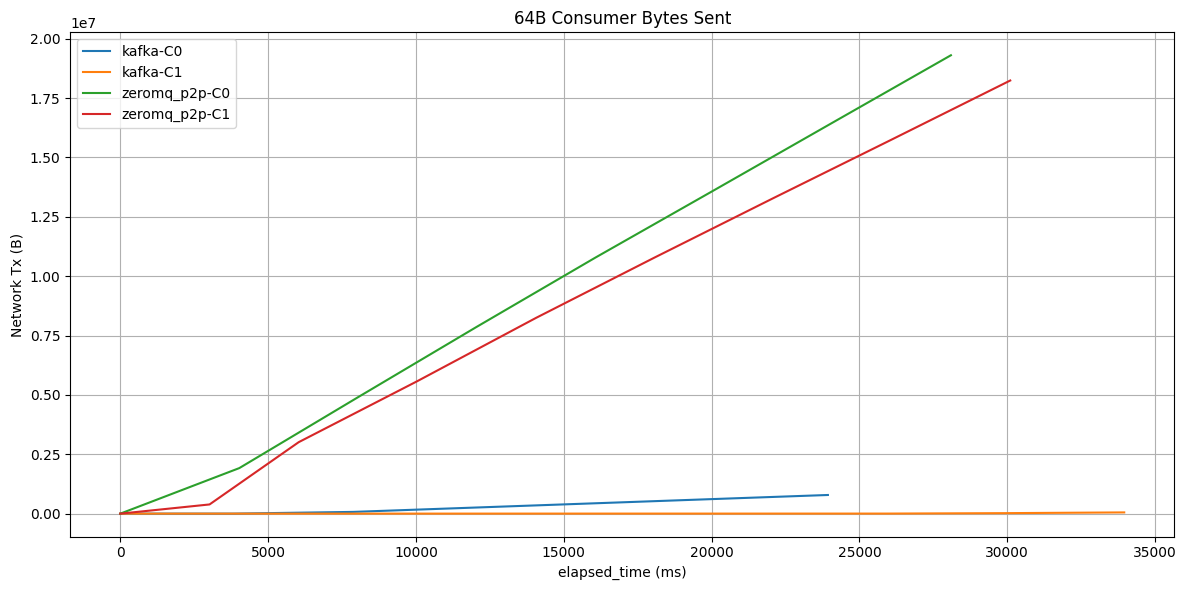

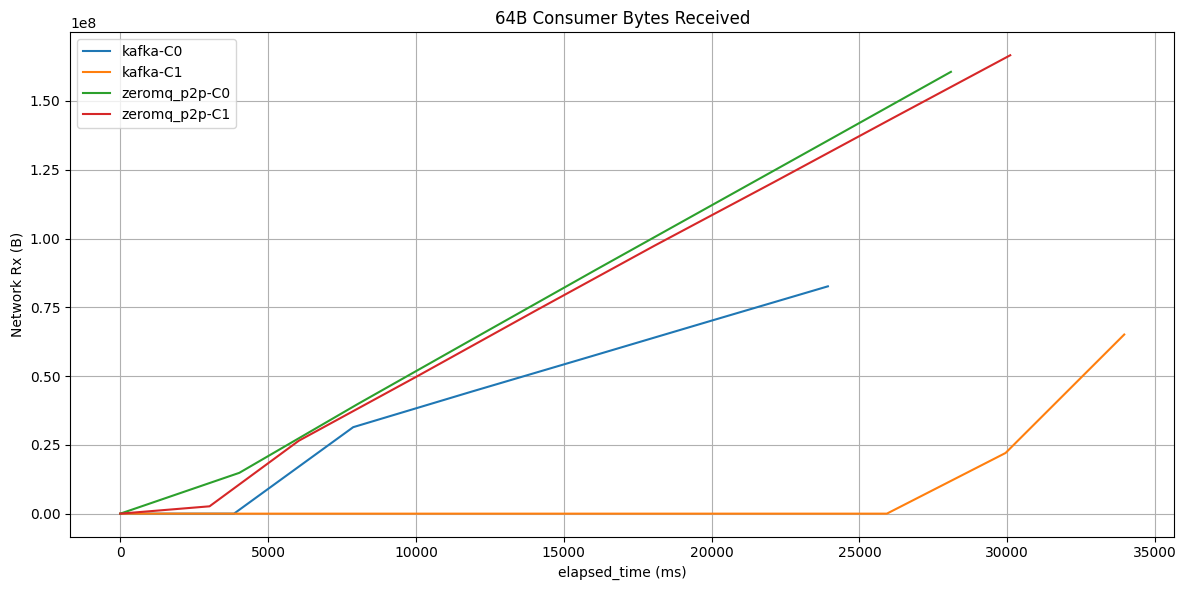

In [37]:
# Slice only publisher data with 64B messages and 4 topics
df_con_64 = filter_stats(stats_df, role = "Consumer", message_size=64)

# Plot CPU Usage (%) for those containers
plot_metric_over_dimension(df_con_64, "cpu_usage_perc", "64B Consumer CPU Usage (%)", unit_y="%")
plot_metric_over_dimension(df_con_64, "memory_usage", "64B Consumer Memory Usage (B)", unit_y="B")
plot_metric_over_dimension(df_con_64, "network_tx", "64B Consumer Bytes Sent", unit_y="B")
plot_metric_over_dimension(df_con_64, "network_rx", "64B Consumer Bytes Received", unit_y="B")

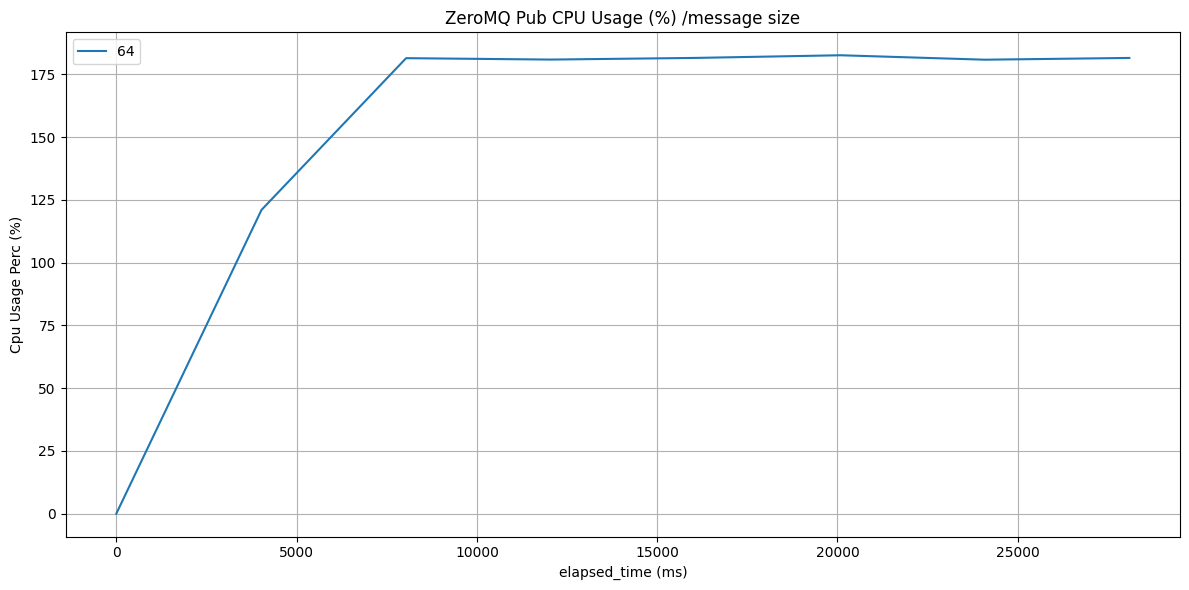

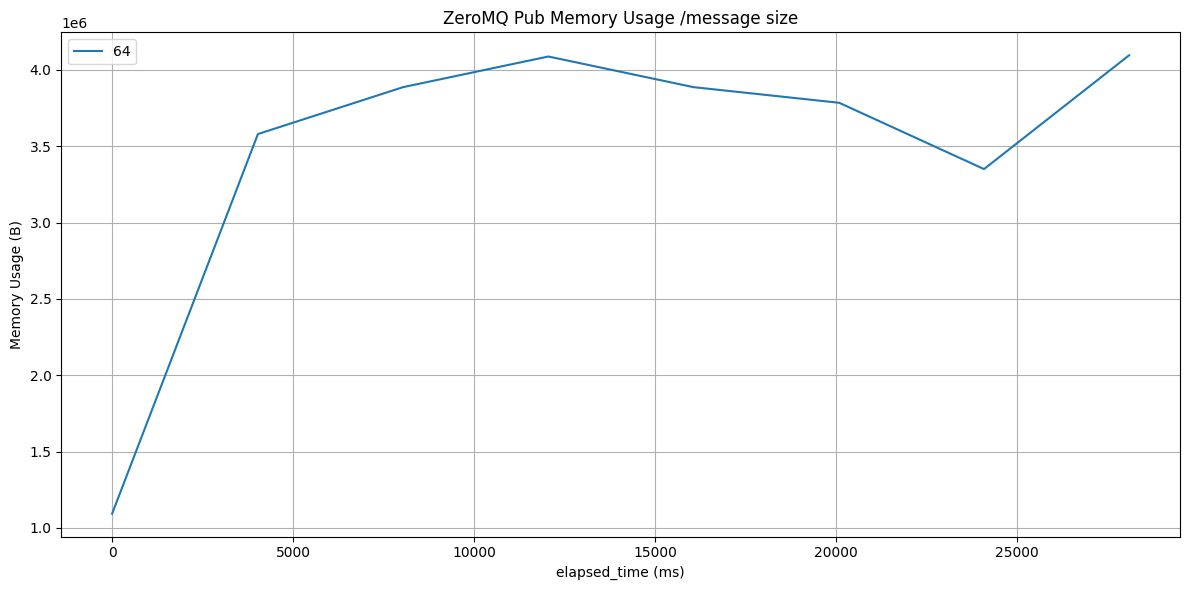

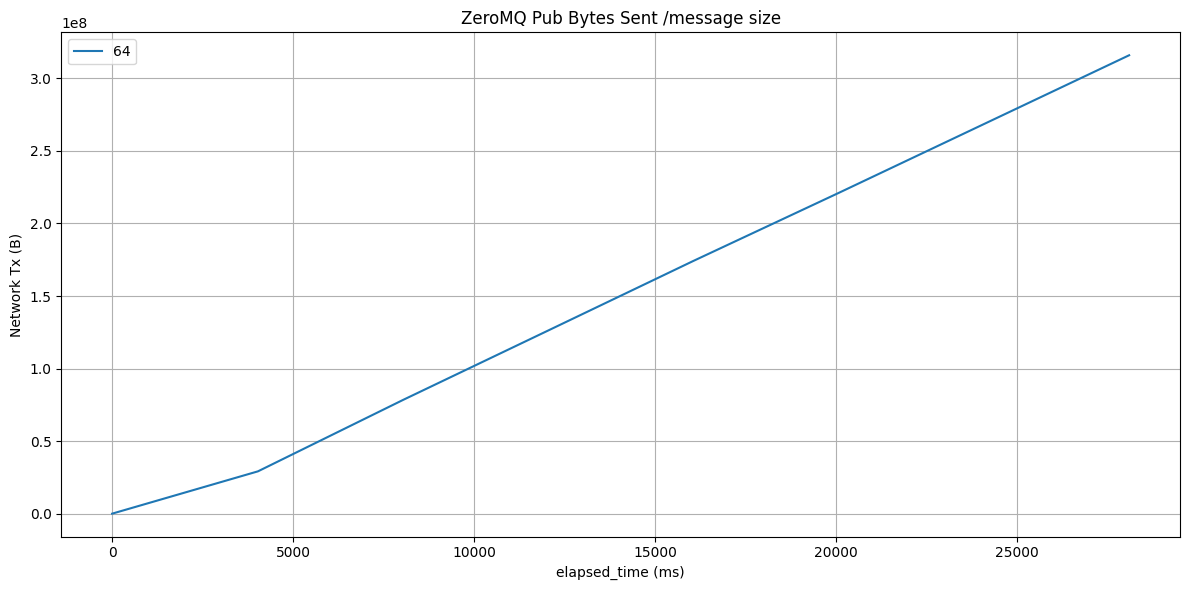

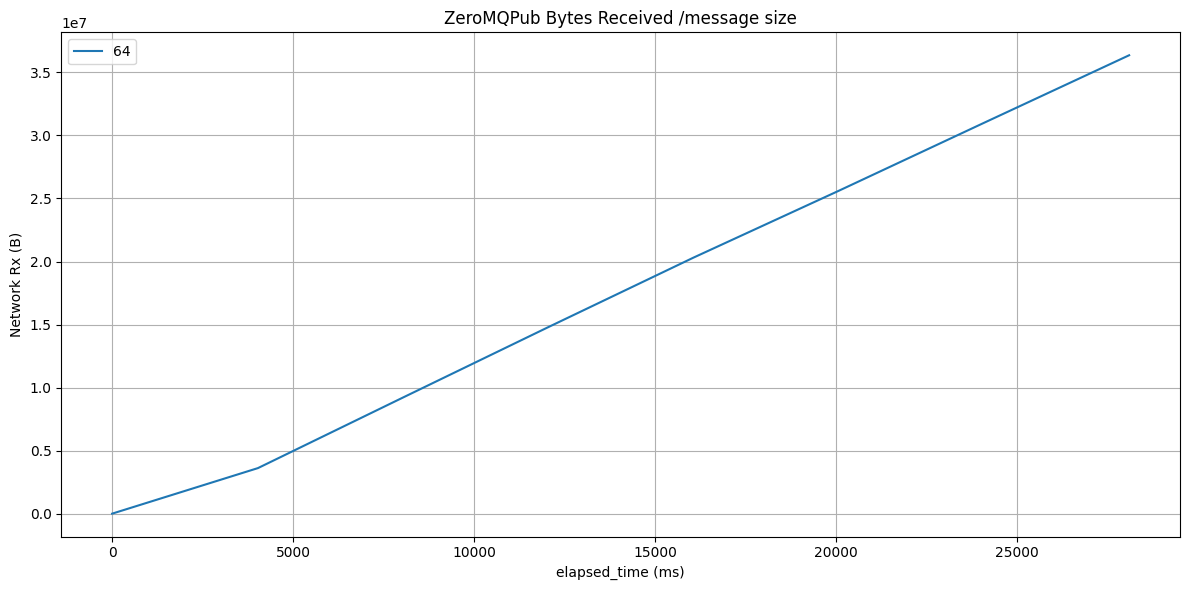

In [38]:
# Slice only publisher data with 64B messages and 4 topics
df_zmq_pub = filter_stats(stats_df, technology="zeromq_p2p", role="Publi")

# Plot CPU Usage (%) for those containers
plot_metric_over_dimension(df_zmq_pub, "cpu_usage_perc", "ZeroMQ Pub CPU Usage (%) /message size", facet_by="message_size", unit_y="%")
plot_metric_over_dimension(df_zmq_pub, "memory_usage", "ZeroMQ Pub Memory Usage /message size", facet_by="message_size", unit_y="B")
plot_metric_over_dimension(df_zmq_pub, "network_tx", "ZeroMQ Pub Bytes Sent /message size", facet_by="message_size", unit_y="B")
plot_metric_over_dimension(df_zmq_pub, "network_rx", "ZeroMQPub Bytes Received /message size", facet_by="message_size", unit_y="B")

In [ ]:
# Slice only publisher data with 64B messages and 4 topics
df_kafka_pub = filter_stats(stats_df, technology="kafka", role="Publi")

# Plot CPU Usage (%) for those containers
plot_metric_over_dimension(df_kafka_pub, "cpu_usage_perc", "Kafka Pub CPU Usage (%) /message size", facet_by="message_size", unit_y="%")
plot_metric_over_dimension(df_kafka_pub, "memory_usage", "Kafka Pub Memory Usage /message size", facet_by="message_size", unit_y="B")
plot_metric_over_dimension(df_kafka_pub, "network_tx", "Kafka Pub Bytes Sent /message size", facet_by="message_size", unit_y="B")
plot_metric_over_dimension(df_kafka_pub, "network_rx", "Kafka Bytes Received /message size", facet_by="message_size", unit_y="B")

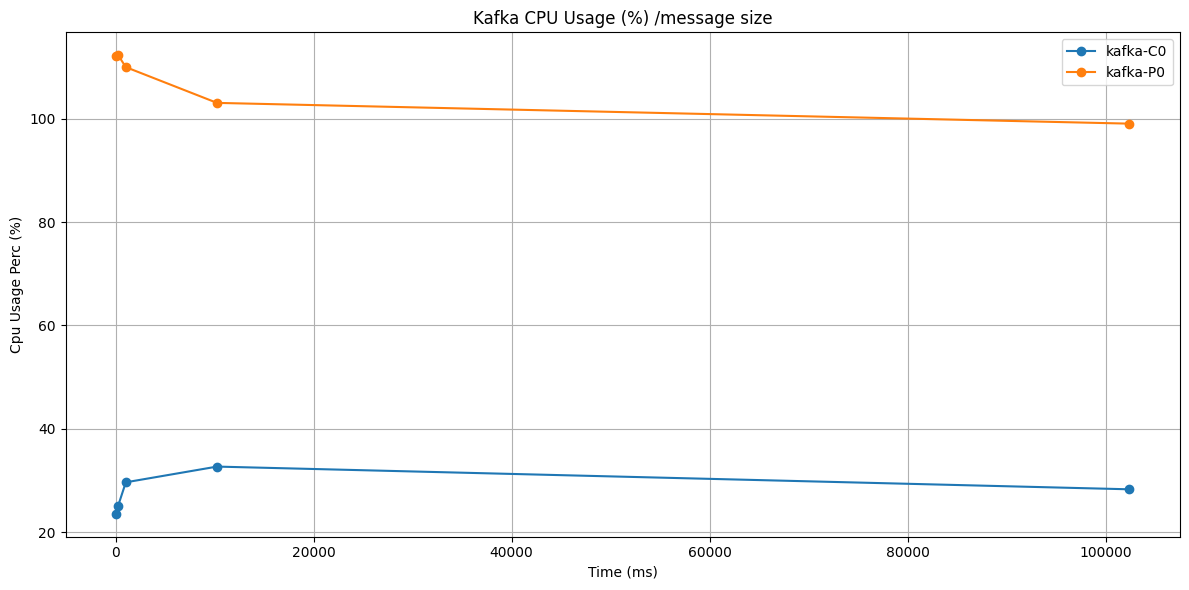

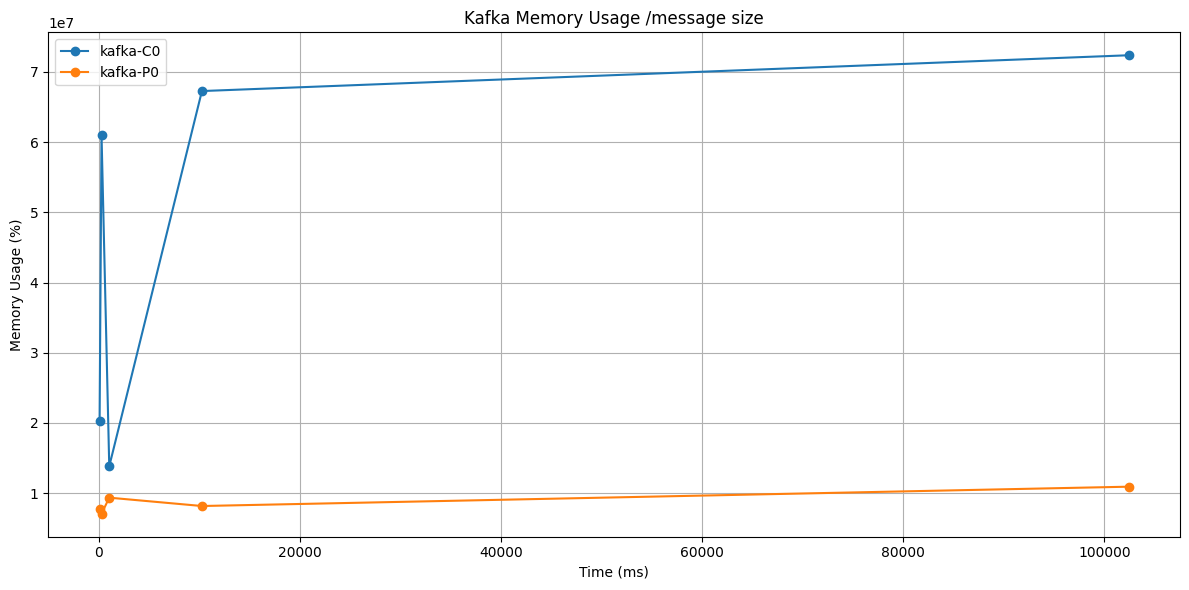

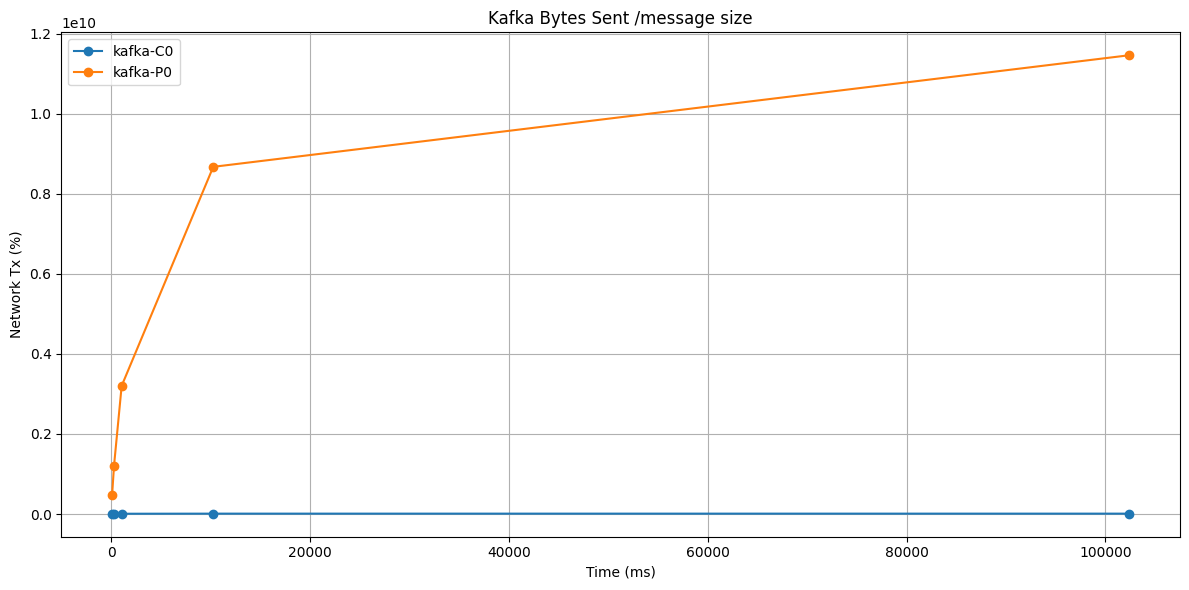

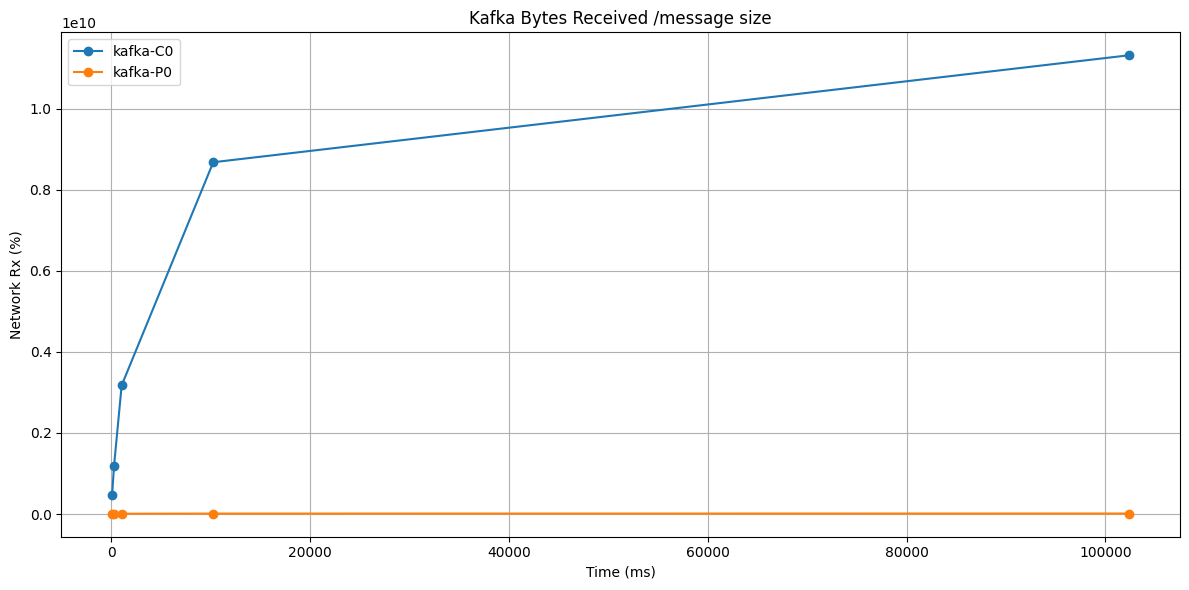

In [16]:
# plot_metric_over_dimension(df_kafka_pub, "memory_usage", "Kafka Pub CPU Usage (%) vs msg size", x="message_size", unit_x="B", unit_y="%")

df_kafka = filter_stats(stats_df, technology="kafka", num_consumers=1, num_topics=1)

plot_metric_over_dimension(df_kafka, "cpu_usage_perc", "Kafka CPU Usage (%) /message size",  x="message_size", unit_x="B", unit_y="%")
plot_metric_over_dimension(df_kafka, "memory_usage", "Kafka Memory Usage /message size",  x="message_size", unit_x="B", unit_y="%")
plot_metric_over_dimension(df_kafka, "network_tx", "Kafka Bytes Sent /message size",  x="message_size", unit_x="B", unit_y="%")
plot_metric_over_dimension(df_kafka, "network_rx", "Kafka Bytes Received /message size",  x="message_size", unit_x="B", unit_y="%")

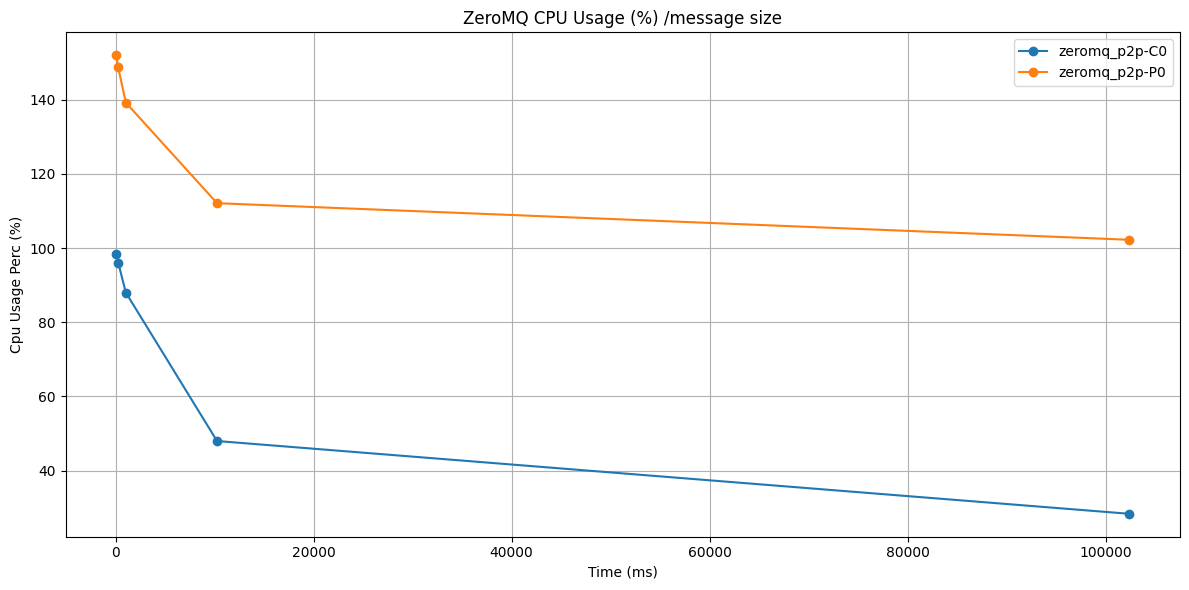

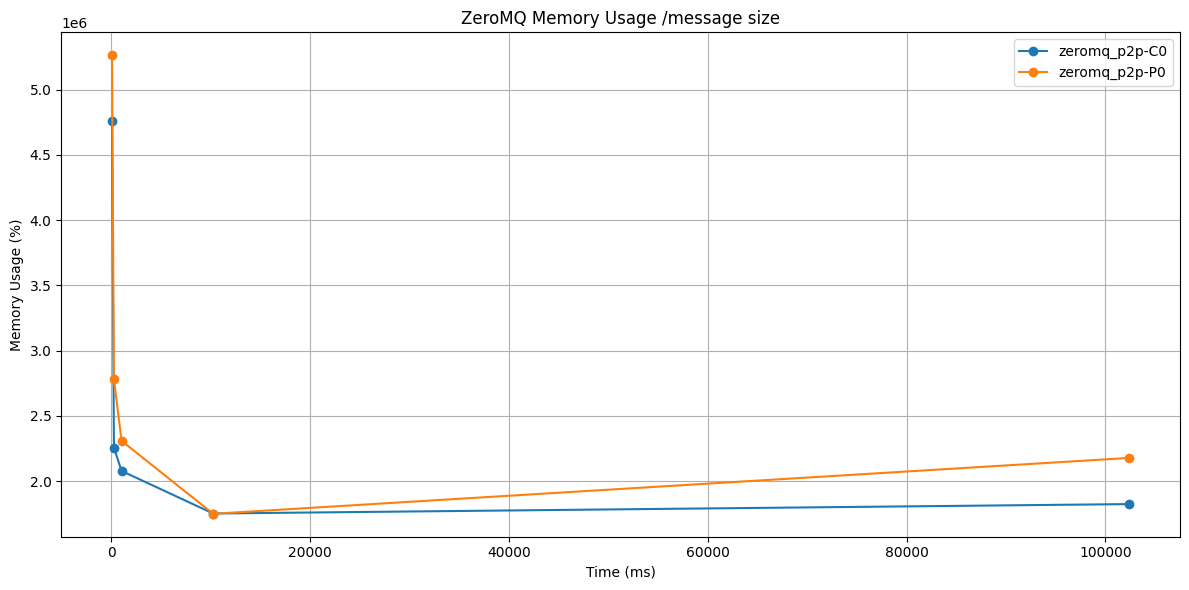

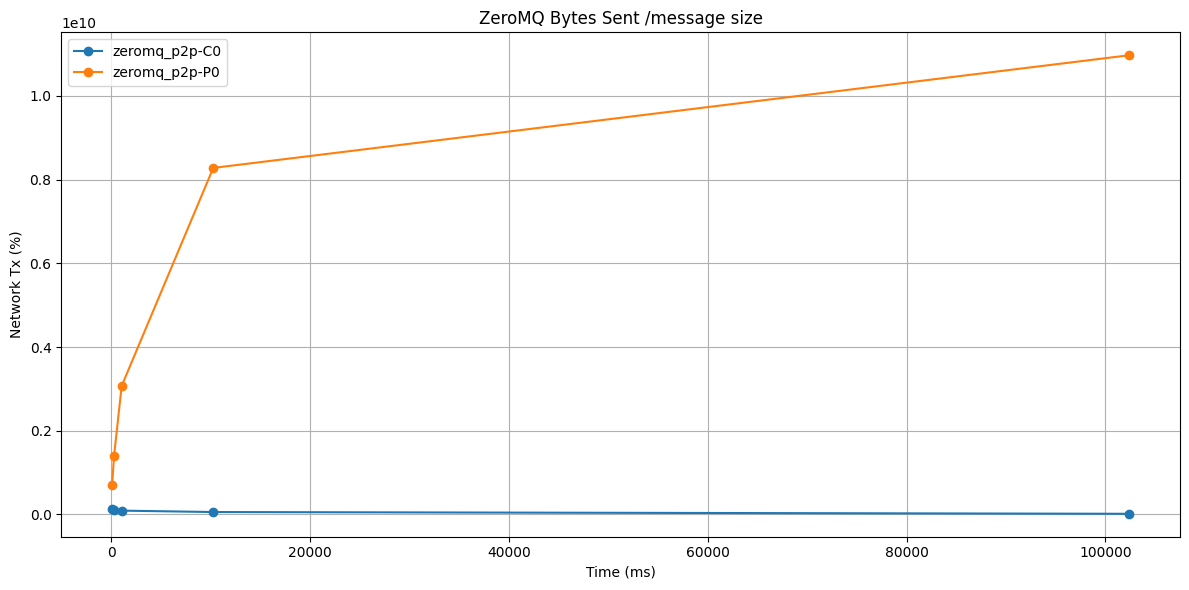

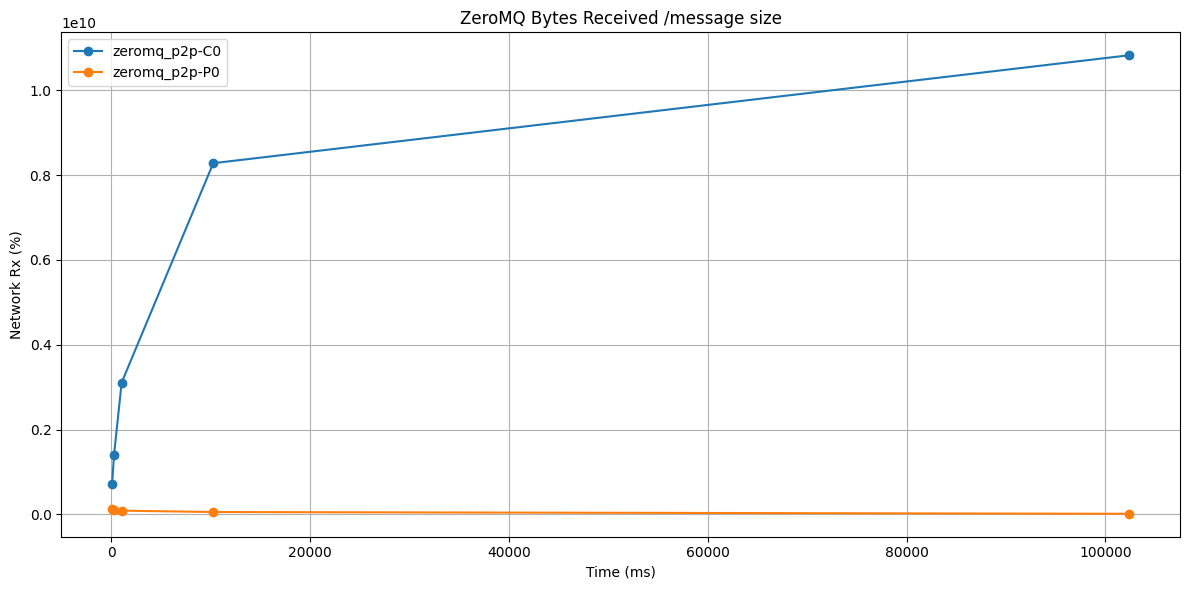

In [17]:
# plot_metric_over_dimension(df_kafka_pub, "memory_usage", "Kafka Pub CPU Usage (%) vs msg size", x="message_size", unit_x="B", unit_y="%")

df_zmq = filter_stats(stats_df, technology="zeromq_p2p", num_consumers=1, num_topics=1)

plot_metric_over_dimension(df_zmq, "cpu_usage_perc", "ZeroMQ CPU Usage (%) /message size",  x="message_size", unit_x="B", unit_y="%")
plot_metric_over_dimension(df_zmq, "memory_usage", "ZeroMQ Memory Usage /message size",  x="message_size", unit_x="B", unit_y="%")
plot_metric_over_dimension(df_zmq, "network_tx", "ZeroMQ Bytes Sent /message size",  x="message_size", unit_x="B", unit_y="%")
plot_metric_over_dimension(df_zmq, "network_rx", "ZeroMQ Bytes Received /message size",  x="message_size", unit_x="B", unit_y="%")